In [1]:
%reset
%load_ext autoreload
%autoreload 2
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from pySurf.data2D_class import Data2D
from pyProfile.profile_class import Profile

In [3]:
from pyProfile.profile import *
from numpy.polynomial import polynomial as P

In [11]:
files=['profiles_RF_F03_3.75w_extracted.txt',
       'profiles_RF_F03_6w_extracted.txt',
       'profiles_RF_F03_12w_extracted.txt'
       ]



outfolder = 'results' 
infolder = r'20191030_F03_postRF_profiles'

In [14]:
cd "profiles_RF"

G:\My Drive\progetti\POOL\pySurf\tutorials\profiles_RF


## Carico le curve

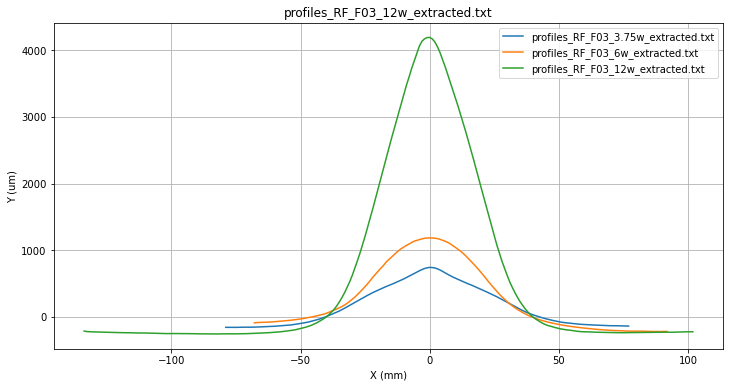

In [15]:
plt.close('all')
pr=[]
plt.figure('data',figsize=(12,6))
plt.grid(1)
plt.xlabel('mm')
plt.ylabel('nm')
for f in files:
    
    x,y =  np.genfromtxt(os.path.join(infolder,f),usecols =[0,1],unpack=True)
    p = Profile(x,y,name=f,units = ['mm','um'])
    p = p* -1  
    #p = p.level(0,zero='bottom')
    p.x = p.x - p.x[np.nanargmax(p.y)]  #align x at peak
    p.plot(label=f)
    pr.append(p)
plt.legend()
plt.savefig(os.path.join(outfolder,'data.png'))

### Tento il fit

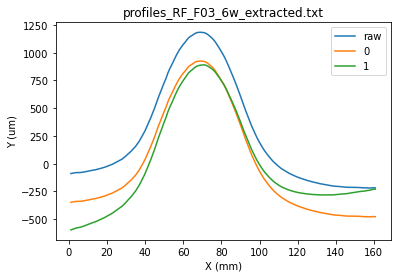

In [16]:
# test senza punti invalidi, mostra che quella livellata con 1 
# e' piu' storta di quella con zero

f=files[1]
x0,y0 =  np.genfromtxt(os.path.join(infolder,f),usecols =[0,1],unpack=True)
p = -Profile(x0,y0,name=f,units = ['mm','um'])
x,y = p()

%matplotlib inline
plt.clf()
p.plot(label='raw')
p.level(0).plot(label = '0')
p.level(1).plot(label = '1')
plt.legend()

fit coefficients: poly([ 259.51100003 -248.75221326])
y mean: 259.51100002914313
y mean incremental var: -0.8128203642820071


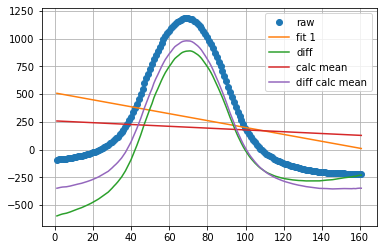

In [17]:
# Con np.polynomial.Polynomial 

from numpy.polynomial import Polynomial as P

# %matplotlib 
plt.clf()
plt.plot(x,y,'o',label = 'raw')
poly = P.fit(x,y,1) #np.polyfit(x,y,1)
fit = poly(x)
plt.plot(x,fit,label = 'fit 1')
plt.plot(x,y-fit,label = 'diff')

#  per confronto faccio anche un calcolo su media di valori
#  e di variazione incrementale, che sembra funzionare meglio. 
incvar = np.diff(y).mean()/(x[1]-x[0])
incvar_approx = x*incvar+np.mean(y)
plt.plot(x,incvar_approx,label = 'calc mean')
plt.plot(x,y - incvar_approx,label = 'diff calc mean')

#p.level(0).plot(label = '0')
#p.level(1).plot(label = '1')
plt.legend()
plt.grid()

print("fit coefficients:",poly)
print("y mean:",np.nanmean(y))
print("y mean incremental var:",incvar)

In [24]:
%qtconsole

Stats for fit:  ['RMS:458 ', 'PV_X:160 , PV_Y:1.49e+03 ']
Stats for incvar:  ['RMS:470 ', 'PV_X:160 , PV_Y:1.33e+03 ']


fit coefficients: [ -3.11361714 511.37261596]
y mean: 259.51100002914313
y mean incremental var: -0.8128203642820071


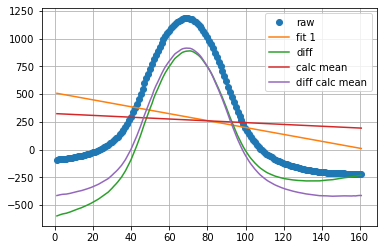

In [28]:
# con polyfit
# %matplotlib 
plt.clf()
plt.plot(x,y,'o',label = 'raw')
poly = np.polyfit(x,y,1)
fit =np.polyval(poly,x)
plt.plot(x,fit,label = 'fit 1')
plt.plot(x,y-fit,label = 'diff')

#  per confronto faccio anche un calcolo su media di valori
#  e di variazione incrementale, che sembra funzionare meglio. 
incvar = np.diff(y).mean()/(x[1]-x[0])
incvar_approx = (x-np.mean(x)) * incvar + np.mean(y)

plt.plot(x,incvar_approx,label = 'calc mean')
plt.plot(x,y - incvar_approx,label = 'diff calc mean')

print('Stats for fit: ',get_stats(x,y - fit))
print('Stats for incvar: ',get_stats(x,y - incvar_approx))
print("\n")

#p.level(0).plot(label = '0')
#p.level(1).plot(label = '1')
plt.legend()
plt.grid()

print("fit coefficients:",poly)
print("y mean:",np.nanmean(y))
print("y mean incremental var:",incvar)

value of peak:
p -156.859037619998
r -219.826255270941
o -255.704739725577


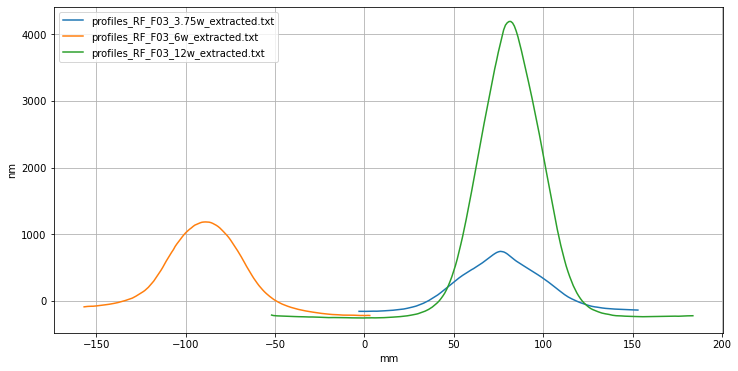

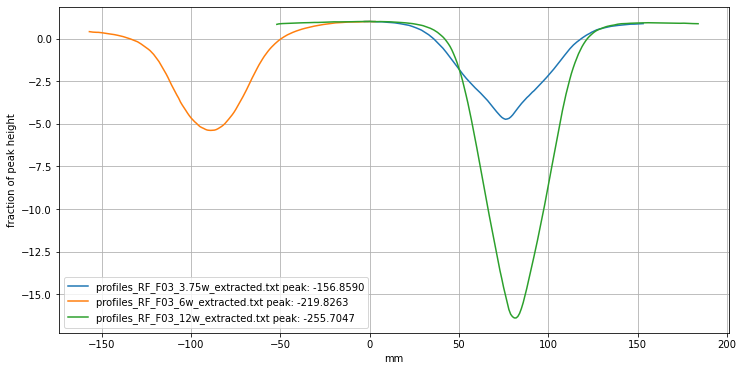

In [30]:
  #altre analisi e allineamenti  
    
plt.figure('aligned to peak',figsize=(12,6))
plt.grid(1)
plt.xlabel('mm')
plt.ylabel('nm')
pk=[]
pr2=[]
for p,f in zip(pr,files):
    x,y=p()
    n=np.nanargmin(y)
    x=x-x[n]
    pr2.append([x,y])
    pk.append(y[n])
    plt.plot(x,y,label=f)
    plt.legend()
plt.savefig(os.path.join(outfolder,'data_aligned.png'))
    
print ("value of peak:")
for yy,f in zip(pk,f):
    print(f,yy)

plt.figure('rescaled',figsize=(12,6))
plt.grid(1)
plt.xlabel('mm')
plt.ylabel('fraction of peak height')
for p,f,pmin in zip(pr2,files,pk):
    x,y=p
    plt.plot(x,y/pmin,label="%s peak: %6.4f"%(f,pmin))
    plt.legend()
plt.savefig(os.path.join(outfolder,'data_rescaled.png'))

In [31]:
## Test per fit lineare


In [32]:
import re


def ffloats(s,fmt='%3.1f'):
    """Format all floats in a string, return formatted string."""
    
    ft = re.sub(r'\d+\.\d+',fmt,s)  # fixed strings
    vl = [float(a) for a in re.compile(r'\d+\.\d+').findall(s)]  #values
    return ft%tuple(vl) #formatted output

def printstats(yf):
    """return a list of strings that are a printed representation of fields 
     of stats (only most used are included) with tag value with floats formatted."""
    
    s = stats.describe(yf)
    
    #very ugly interface in stats
    # DescribeResult(
    #                nobs=161, 
    #                minmax=(-749.565364748108, 660.3055086898696), 
    #                mean=259.51100002914336, 
    #                variance=141773.08588756813, 
    #                skewness=-0.8690193389116946, 
    #                kurtosis=-0.21634176872548716)
    
    # build tags for fields of interest, missing in stats 
    # they must match vals
    header = ['nobs','minmax','mean','var']
    vals = s[:-2]
    outdesc = [h+': '+ffloats(str(v)) for h,v in zip(header,vals)]
    
    
    return outdesc
    # ffloats(stats.describe(yf)[:-2] 
    # Note that stats returns a describe object of unclear properties
    #  can be sliced, but then becomes array and lose fields and repr, otherwise
    #  is some kind of iterator.

def printpoly(pF):
    """return a list of strings that are a printed representation of Polynomial
    object properties (`coef`,`window`,`domain`) with floats formatted.
        
    print e.g. with: `print("\n".join(printpoly(pF)))`"""
    
    header = ['coef','win','dom']
    vals = [pF.coef,pF.window,pF.domain]
    outdesc = [h+': '+ffloats(str(v)) for h,v in zip(header,vals)]
    
    return outdesc #(pF.__repr__())



In [33]:
#inizializzazione
%matplotlib inline
from matplotlib import gridspec

from numpy.polynomial import Polynomial as P
from numpy.polynomial import Legendre as L
from numpy.polynomial import Chebyshev as C
from scipy import stats

#carica singolo profilo, aggiusta scale.
f=files[1]

x0,y0 =  np.genfromtxt(os.path.join(infolder,f),usecols =[0,1],unpack=True)
p = -Profile(x0,y0,name=f,units = ['mm','um'])
x,y = p()
pF = P.fit(x,y,3)

In [34]:
# test printstats
print("\n".join(printstats(y)))
print("\n---\n")
print(printpoly(pF))


nobs: 161
minmax: (-219.8, 1184.7)
mean: 259.5
var: 232200.1

---

['coef: [  646.8  -872.2 -1147.7  1026.4]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]']


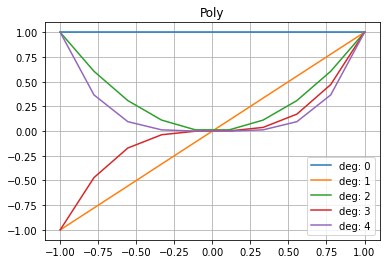

Text(0.5, 1.0, 'Legendre')

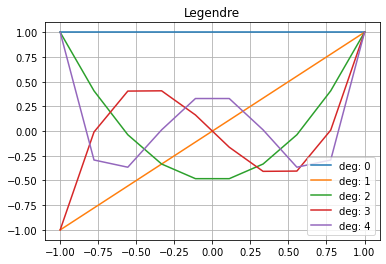

In [35]:
# plot poly vs legendre

def plotPvsL(P=P):
    x= np.linspace(-1,1,10)
    deg = 5
    for i in np.arange(deg):
        p = P.basis(i)
        plt.plot(x,p(x),label = 'deg: %i'%i)
    plt.legend()
    plt.grid(1)
    
plotPvsL()
plt.title('Poly')
plt.show()
plt.clf()
plotPvsL(L)
plt.title('Legendre')


----
POLY:
For polynomial  ['coef: [259.5]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (259.5, 259.5)', 'mean: 259.5', 'var: 3.3e-27']
residuals 
 ['nobs: 161', 'minmax: (-479.3, 925.2)', 'mean: 0.0', 'var: 232200.1']
--
LEGENDRE:

For polynomial  ['coef: [259.5]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (259.5, 259.5)', 'mean: 259.5', 'var: 3.3e-27']
residuals 
 ['nobs: 161', 'minmax: (-479.3, 925.2)', 'mean: 0.0', 'var: 232200.1']

----



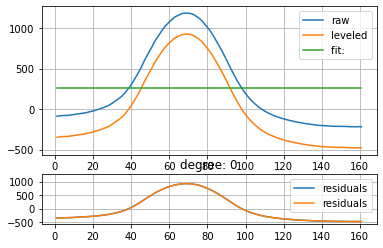


----
POLY:
For polynomial  ['coef: [ 259.5 -248.8]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (10.8, 508.3)', 'mean: 259.5', 'var: 21014.2']
residuals 
 ['nobs: 161', 'minmax: (-597.0, 890.7)', 'mean: -4.9e-13', 'var: 211185.8']
--
LEGENDRE:

For polynomial  ['coef: [ 259.5 -248.8]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (10.8, 508.3)', 'mean: 259.5', 'var: 21014.2']
residuals 
 ['nobs: 161', 'minmax: (-597.0, 890.7)', 'mean: -4.9e-13', 'var: 211185.8']

----



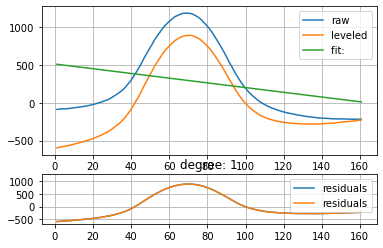


----
POLY:
For polynomial  ['coef: [  646.8  -248.8 -1147.7]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (-749.6, 660.3)', 'mean: 259.5', 'var: 141773.1']
residuals 
 ['nobs: 161', 'minmax: (-427.9, 531.0)', 'mean: -1.5e-13', 'var: 90427.0']
--
LEGENDRE:

For polynomial  ['coef: [ 264.3 -248.8 -765.1]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (-749.6, 660.3)', 'mean: 259.5', 'var: 141773.1']
residuals 
 ['nobs: 161', 'minmax: (-427.9, 531.0)', 'mean: -3.4e-14', 'var: 90427.0']

----



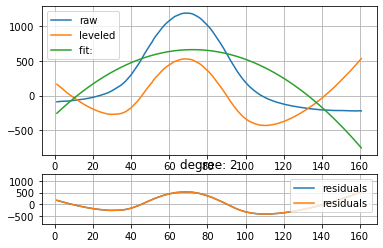


----
POLY:
For polynomial  ['coef: [  646.8  -872.2 -1147.7  1026.4]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (-654.9, 778.6)', 'mean: 259.5', 'var: 166911.4']
residuals 
 ['nobs: 161', 'minmax: (-417.5, 566.2)', 'mean: -1.1e-12', 'var: 65288.7']
--
LEGENDRE:

For polynomial  ['coef: [ 264.3 -256.4 -765.1  410.5]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (-654.9, 778.6)', 'mean: 259.5', 'var: 166911.4']
residuals 
 ['nobs: 161', 'minmax: (-417.5, 566.2)', 'mean: -2.8e-15', 'var: 65288.7']

----



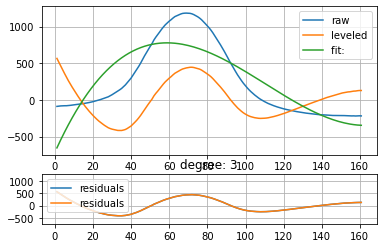


----
POLY:
For polynomial  ['coef: [  856.9  -872.2 -3223.0  1026.4\n  2391.6]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (-420.4, 914.2)', 'mean: 259.5', 'var: 201989.7']
residuals 
 ['nobs: 161', 'minmax: (-398.3, 272.6)', 'mean: -5.6e-14', 'var: 30210.4']
--
LEGENDRE:

For polynomial  ['coef: [ 260.9 -256.4 -782.0  410.5  546.7]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (-420.4, 914.2)', 'mean: 259.5', 'var: 201989.7']
residuals 
 ['nobs: 161', 'minmax: (-398.3, 272.6)', 'mean: -4.5e-14', 'var: 30210.4']

----



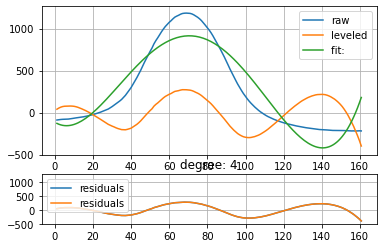


----
POLY:
For polynomial  ['coef: [  856.9 -1666.6 -3223.0  4688.8\n  2391.6 -3256.3]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (-254.4, 1028.9)', 'mean: 259.5', 'var: 218600.5']
residuals 
 ['nobs: 161', 'minmax: (-348.4, 192.0)', 'mean: -2.9e-13', 'var: 13599.5']
--
LEGENDRE:

For polynomial  ['coef: [ 260.9 -248.9 -782.0  428.3  546.7\n -413.5]', 'win: [-1.  1.]', 'dom: [  1.0 160.8]'] 

Stats for
data 
 ['nobs: 161', 'minmax: (-219.8, 1184.7)', 'mean: 259.5', 'var: 232200.1']
fit 
 ['nobs: 161', 'minmax: (-254.4, 1028.9)', 'mean: 259.5', 'var: 218600.5']
residuals 
 ['nobs: 161', 'minmax: (-348.4, 192.0)', 'mean: -7.9e-14', 'var: 13599.5']

----



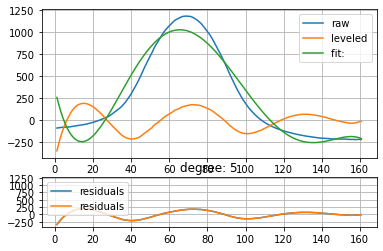

'\nd=2\npF = test_level_profile(x,y,d,plot=True)\n'

In [36]:
# test_level_profile su x e y
    
def test_level_profile(x,y,deg,P=P,plot=False):
    """ P is the type of polynomial from numpy.polynomial.
        if plot is False only printed output is generated. """
    
    pF = P.fit(x,y,deg)
    yf = pF(x)
    
    print("For polynomial ",printpoly(pF),'\n')
    print('Stats for\ndata \n',printstats(y))
    print('fit \n',printstats(yf))
    print('residuals \n',printstats(y-yf))
    
    if plot:
        # plot setup
        plt.clf()
        gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 

        # plot 1
        ax1 = plt.subplot(gs[0])
        plt.plot(x,y,label = 'raw')
        xl,yl =level_profile(x,y,deg)
        plt.plot(xl,yl,label = 'leveled')
        plt.plot(x,yf,label = 'fit: ')
        #plt.plot(x,y-yf,'--',label='residuals: ')
        plt.grid(1)
        plt.legend()
        ## plot 2
        plt.subplot(gs[1],sharex=ax1,sharey=ax1)
        plt.plot(x,y-yf,label='residuals')
        
        plt.plot(x,y-yf,label='residuals')
        plt.grid(1)
        plt.legend()
        
        plt.title('degree: %i'%(deg)) # plt.suptitle('degree: %i'%(deg))
    
    return pF

  
maxorder=6

for d in np.arange(maxorder):
    print('\n----\nPOLY:')
    plt.subplot(211)
    pF = test_level_profile(x,y,d,plot=True)
    plt.subplot(212)
    print('--\nLEGENDRE:\n')
    pF = test_level_profile(x,y,d,plot=True,P=L)
    print('\n----\n')
    plt.show()
"""
d=2
pF = test_level_profile(x,y,d,plot=True)
"""  

In [37]:
maxdeg = 6
for i in np.arange(maxdeg):
    p = P.fit(x,y,i)
    print('degree ',i,p.coef)

for i in np.arange(maxdeg):
    p = L.fit(x,y,i)
    print('degree ',i,p.coef)

degree  0 [259.51100003]
degree  1 [ 259.51100003 -248.75221326]
degree  2 [  646.84594514  -248.75221326 -1147.65909662]
degree  3 [  646.84594514  -872.23935428 -1147.65909662  1026.36907827]
degree  4 [  856.93478443  -872.23935428 -3222.98428777  1026.36907827
  2391.62877333]
degree  5 [  856.93478443 -1666.63726375 -3222.98428777  4688.8279013
  2391.62877333 -3256.27272064]
degree  0 [259.51100003]
degree  1 [ 259.51100003 -248.75221326]
degree  2 [ 264.29291293 -248.75221326 -765.10606441]
degree  3 [ 264.29291293 -256.41790732 -765.10606441  410.54763131]
degree  4 [ 260.93244317 -256.41790732 -782.01117851  410.54763131  546.65800533]
degree  5 [ 260.93244317 -248.88597468 -782.01117851  428.29884024  546.65800533
 -413.49494865]


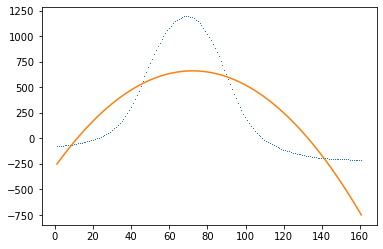

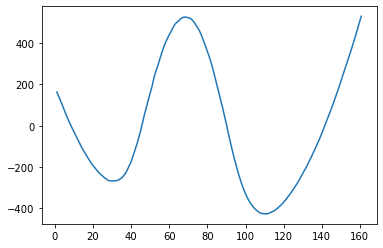

In [38]:

plt.figure(1)
plt.clf()
plt.plot(x,y,',')
Pinf=P.fit(x,y,2)(x)
#xl,yl =level_profile(x,y,1)
#plt.plot(xl,yl,'+')
plt.plot(x,Pinf)
plt.figure(2)
plt.plot(x,y-Pinf)

In [39]:
Pinf

array([-2.52060938e+02, -2.26658185e+02, -2.01614076e+02, -1.76928610e+02,
       -1.52601787e+02, -1.28633608e+02, -1.05024072e+02, -8.17731799e+01,
       -5.88809312e+01, -3.63473259e+01, -1.41723641e+01,  7.64395423e+00,
        2.91016291e+01,  5.02006605e+01,  7.09410484e+01,  9.13227929e+01,
        1.11345894e+02,  1.31010351e+02,  1.50316166e+02,  1.69263336e+02,
        1.87851863e+02,  2.06081747e+02,  2.23952987e+02,  2.41465584e+02,
        2.58619537e+02,  2.75414847e+02,  2.91851513e+02,  3.07929536e+02,
        3.23648915e+02,  3.39009651e+02,  3.54011744e+02,  3.68655193e+02,
        3.82939998e+02,  3.96866160e+02,  4.10433679e+02,  4.23642554e+02,
        4.36492786e+02,  4.48984374e+02,  4.61117319e+02,  4.72891620e+02,
        4.84307278e+02,  4.95364292e+02,  5.06062663e+02,  5.16402390e+02,
        5.26383474e+02,  5.36005914e+02,  5.45269711e+02,  5.54174865e+02,
        5.62721375e+02,  5.70909242e+02,  5.78738465e+02,  5.86209044e+02,
        5.93320980e+02,  